# Topic extraction from the GEPRiS dataset and creation of an user-centric visualisation
Author: Tim Korjakow        
Summer term 2018      
Freie Universität Berlin     
Fachgebiet Human-Centered Computing

![Process graph](nlpflowchart.svg)

In [1]:
# general imports
import numpy as np
#import sklearn
import os

# data wrangling
import json
import spacy
spacy.prefer_gpu()
from spacy_langdetect import LanguageDetector
import psycopg2
from multiprocessing import Pool, cpu_count

# document embedding
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, strip_short
import scipy

# topic extraction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF as NonnegativeMatrixFactorization
from gensim.models.coherencemodel import CoherenceModel
import keras
from sklearn.preprocessing import normalize


#clustering
from numpy import triu_indices
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration
from sklearn.neighbors import radius_neighbors_graph

# projection into 2d
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

# linearization
from lapjv import lapjv
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from numpy.linalg import norm
from sklearn.preprocessing import normalize

# quality metrics of the clustering
from sklearn.metrics import silhouette_samples

# interactivity
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Dropdown, FloatSlider, fixed
import ipywidgets as widgets
from IPython.display import display, Javascript, HTML
import pickle

#2d plot
from bokeh.io import output_notebook, show, export_png
from bokeh.models import ColumnDataSource, OpenURL, TapTool, LinearAxis, Grid
from bokeh.plotting import figure
from bokeh.models.glyphs import VBar
from bokeh.palettes import d3, brewer, mpl, inferno
from bokeh.layouts import row, column
output_notebook()
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# 3d plot
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True) # for offline mode use

Using TensorFlow backend.
/tf/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/tf/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/tf/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/tf/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Loading BokehJS ...

## Loading and Cleaning
The first step in every NLP project which works with texts is always the preparation of the input data. In this example the Project dump from GEPRIS is loaded and the project descriptions are extracted. After that the texts get cleaned by removing all non-alphabetic chars and all stopwords from the texts. English texts are getting filtered in oder to make the analysis simpler and more comparable.

In [ ]:
with open(os.environ['PG_PASSWORD']) as password_file:
    password = password_file.read().strip()
    conn = psycopg2.connect(dbname="ikon", user="ikonuser", password=password, port=5432, host='Postgres')

class DataLoader(object):
    def __init__(self, query, clean=True, stream=False, workers=cpu_count()):
        self.query = query
        self.data = self.loadFromDB(self.query).fetchall()
            
    def __iter__(self):
        self.pos = 0
        return self
    
    def __next__(self):
        if self.pos >= len(self.data):
            raise StopIteration
        self.pos += 1
        return self.data[self.pos-1]
    
    def  __getitem__(self, pos):
        text, *args = self.data[pos]
        return self.data[self.pos]
    
    def __len__(self):
        return len(self.data)
    
    def __str__(self):
        return str(self.data)
    
    def loadFromDB(self, query):
        cursor = conn.cursor()
        cursor.execute(query)
        return cursor
        
class DataPreprocessor(DataLoader):
    def __init__(self, query, clean=True, stream=False, workers=cpu_count()):
    def __str__(self):
        return str(self.data)
    
    def loadFromDB(self, query):
        cursor = conn.cursor()
        cursor.execute(query)
        return cursor
        
class DataPreprocessor(DataLoader):
    def __init__(self, query, clean=True, stream=False, workers=cpu_count()):
        self.query = query
        self.clean = clean
        self.nlp = spacy.load('de', disable=["ner", "tagger"])
            for text, *args in self.data:
                file.write("%s\n" % " ".join(text))
    
        self.nlp.Defaults.stop_words |= self.loadEnglishStopwords()
        data = self.chunkify(self.loadFromDB(self.query).fetchall(), workers)
        with Pool(workers) as pool:
            self.data = [item for sublist in pool.map(self.preprocessText, data) for item in sublist]
        
        self.filepath = get_tmpfile(str(hash(tuple(self.data))))
        with open(self.filepath, "w") as file:
            for text, *args in self.data:
        text, *args = self.data[pos]
        return TaggedDocument(text, [pos])
    
    def getIDs(self):
        return [id for (text, id, title) in self.data]
    
    def getTitles(self):
        return [title for (text, id, title) in self.data]
        
    def  __getitem__(self, pos):
        text, *args = self.data[pos]
            return set(json.load(datafile))

    def loadEnglishStopwords(self):
        with open('../data/stopwords_eng.json', 'r') as datafile:
            return set(json.load(datafile))
        
    def preprocessText(self, results):
        texts, *args = zip(*results)
        data = []
        for doc, *args in zip(self.nlp.pipe(texts, batch_size=100, n_threads=-1), *args):
            if(doc._.language['language'] == 'de'):
                data.append((tuple([token.lemma_ for token in doc if self.filterType(token)]), *args))
        return data
    
    def chunkify(self, lst, n):
        return [lst[i::n] for i in range(n)]
        
    def filterType(self, token):
        return token.is_alpha and not (token.is_stop or token.like_num or token.is_punct) and len(token.lemma_) > 3            return set(json.load(datafile))


In [3]:
traindata = %time DataLoader('''SELECT FIRST(project_abstract), FIRST(id), FIRST(title) \
                                FROM projects WHERE project_abstract NOT LIKE '%Keine Zusammenfassung%' \
                                GROUP BY project_abstract \
                                ;''')
mfndata = DataLoader('''SELECT abstract, id, title \
                        FROM project_view \
                        WHERE institution_id = 13232 AND abstract NOT LIKE '%Zusammenfassung%';''')

CPU times: user 5.09 s, sys: 1.6 s, total: 6.69 s
Wall time: 18min 12s


In [10]:
mfndata = DataLoader('''SELECT summary, id, titelprojekt \
                        FROM mfnprojects \
                        WHERE summary NOT LIKE '%Zusammenfassung%';''')

## Data
Firstly we are going to have a look at the type of texts we have:

In [4]:
textlength_histogram = DataLoader('''SELECT text_length, COUNT(text_length) \
                                     FROM ( \
                                         SELECT array_length(regexp_split_to_array(trim(project_abstract), '\s'), 1) as text_length \
                                         FROM projects \
                                     ) l \
                                     GROUP BY text_length \
                                     ;''')

In [5]:
def plot_histogram(bins, name):
    fig = go.Figure(data=[go.Bar(x=[x[0] for x in bins], y=[x[1] for x in bins], marker_color='black')])
    fig.update_layout(
        title=go.layout.Title(
            xref="paper",
            x=0
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text="Document length in #words",
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#7f7f7f"
                )
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text="Absolute frequency in the corpus",
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#7f7f7f"
                )
            )
        )
    )
    fig.update_layout(yaxis_type="log")
    fig.show()

In [6]:
plot_histogram(textlength_histogram, 'histogram')

As one can see there is a peak at word count 3 and one at approximatly 100. The first one corresponds to all projects which do not have descriptions, because they are described with "Keine Zusammenfassung vorhanden". The latter peak on the other hand is produced by projects from a fund which uses the same descriptions for all its projects which are financed through the DFG. 

In [7]:
cleaned_textlength_histogram = DataLoader('''SELECT text_length, COUNT(text_length) \
                                     FROM ( \
                                         SELECT array_length(regexp_split_to_array(trim(FIRST(project_abstract)), '\s'), 1) as text_length \
                                         FROM projects \
                                         WHERE project_abstract NOT LIKE '%Keine Zusammenfassung%' \
                                         GROUP BY project_abstract \
                                     ) l \
                                     GROUP BY text_length \
                                     ;''')

In [8]:
plot_histogram(cleaned_textlength_histogram, 'cleaned_histogram')

## Document Embedding

### TF-IDF
*Summary*:
This technique vectorizes a corpus, e.g. a collection of documents, by counting all appearences of words in the corpus and computing the tf-idf measure for each document, word pair.

In [ ]:
class TfidfModelExtended(TfidfModel):
    def top_words(self, vector, dct=None ,topn=5):
        if isinstance(vector, scipy.sparse.csr_matrix):
            vector = vector.todense()
        return [dct.get(entry) for entry in np.argpartition(np.asarray(vector).ravel(), -topn)[-topn:]]

In [ ]:
dct = %time Dictionary(doc.words for doc in traindata)  # fit dictionary
traincorpus = [dct.doc2bow(doc.words) for doc in traindata]  # convert corpus to BoW format
tfidf_model = %time TfidfModelExtended(traincorpus)  # fit model

CPU times: user 17.4 s, sys: 171 ms, total: 17.6 s
Wall time: 17.7 s
CPU times: user 5.09 s, sys: 20.7 ms, total: 5.11 s
Wall time: 5.11 s


In [ ]:
mfncorpus = [dct.doc2bow(doc.words) for doc in mfndata]  # convert corpus to BoW format
docs_vectorized_tfidf = corpus2csc(tfidf_model[mfncorpus]).T

### Doc2Vec
*Summary*:
This technique vectorizes a corpus, e.g. a collection of documents, by counting all appearences of words in the corpus and computing the tf-idf measure for each document, word pair.

In [ ]:
class Doc2VecExtended(Doc2Vec):
    def top_words(self, vector, dct=None, topn=5):
        return [word for word, prob in self.wv.similar_by_vector(vector, topn=topn)]

In [ ]:
print('Doc2Vec setup and vocabulary building:')
doc2vec_model = %time Doc2VecExtended(corpus_file=traindata.filepath, total_words=dct.num_pos, vector_size=100, window=20, min_count=4, workers=cpu_count(), epochs=30)
print('Doc2Vec training:')
%time doc2vec_model.train(corpus_file=traindata.filepath, total_words=dct.num_pos, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

Doc2Vec setup and vocabulary building:


/tf/.venv/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



Doc2Vec setup and vocabulary building:
CPU times: user 12min 58s, sys: 2.41 s, total: 13min 1s
Wall time: 3min 33s
Doc2Vec training:
CPU times: user 12min 47s, sys: 2.49 s, total: 12min 49s
Wall time: 3min 25s


In [ ]:
docs_vectorized_doc2vec = np.array([doc2vec_model.infer_vector(doc.words) for doc in mfndata])

# Topic extraction

## Latent Semantic Analysis
*Summary*:
The LSA transforms an corpus from its word space given by the tf-idf matrice into its semantic space. In this semantic space the dimensions denote topics in the corpus and every document vector is a linear combination of all the implicitly extracted topics.

In [ ]:
def LSA(tfs,num_topics=40):
    lsa = TruncatedSVD(n_components=num_topics, random_state=0).fit(tfs)
    return lsa.transform(tfs), lsa

## Autoencoder
Summary: **Coming soon**

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

def create_autoencoder(input_dim, encoding_dim=50):
    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    return autoencoder, encoder, decoder

W0809 11:23:45.057801 140118268290880 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 11:23:45.116694 140118268290880 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 11:23:45.123407 140118268290880 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 11:23:45.164699 140118268290880 deprecation_wrapper.py:119] From /tf/.venv/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
input_train_doc2vec = normalize(doc2vec_model.docvecs.vectors_docs)
input_test_doc2vec = normalize(docs_vectorized_doc2vec)
autoencoder_doc2vec, encoder_doc2vec, decoder_doc2vec = create_autoencoder(doc2vec_model.docvecs.vectors_docs.shape[1])
history = autoencoder_doc2vec.fit(input_train_doc2vec, input_train_doc2vec,
                epochs=75,
                batch_size=256,
                shuffle=True,
                validation_data=(input_test_doc2vec, input_test_doc2vec),
                verbose=0)

Train on 82241 samples, validate on 82 samples
Epoch 1/150
82241/82241 [==============================] - 1s 10us/step - loss: 0.1178 - val_loss: 0.0093
Epoch 2/150
82241/82241 [==============================] - 1s 7us/step - loss: 0.0037 - val_loss: 0.0017
Epoch 3/150
82241/82241 [==============================] - 1s 7us/step - loss: 9.9958e-04 - val_loss: 8.8345e-04
Epoch 4/150
82241/82241 [==============================] - 1s 7us/step - loss: 5.3391e-04 - val_loss: 6.3468e-04
Epoch 5/150
82241/82241 [==============================] - 1s 7us/step - loss: 3.5651e-04 - val_loss: 5.1847e-04
Epoch 6/150
82241/82241 [==============================] - 1s 7us/step - loss: 2.6449e-04 - val_loss: 4.5237e-04
Epoch 7/150
82241/82241 [==============================] - 1s 7us/step - loss: 2.0871e-04 - val_loss: 4.1018e-04
Epoch 8/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.7153e-04 - val_loss: 3.8114e-04
Epoch 9/150
82241/82241 [==============================] - 1s 7u

In [14]:
# Plot training & validation loss values
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(75)), y=history.history['loss'], name='train_loss'))
fig.add_trace(go.Scatter(x=list(range(75)), y=history.history['val_loss'], name='vall_loss'))
fig.update_xaxes(title_text="Number of epochs")
fig.update_yaxes(title_text="Loss")
fig.update_layout(yaxis_type="log",
                  width=1000, 
                  height=600)
fig.show()

In [15]:
fig = go.Figure()

err_lsa = []
err_aut = []
spar_lsa = []
spar_aut = []
dims = list(range(10,20,5))
for dim in dims:
    print(dim)
    autoencoder, *args = create_autoencoder(doc2vec_model.docvecs.vectors_docs.shape[1], encoding_dim=dim)
    autoencoder.fit(input_train_doc2vec, input_train_doc2vec,
                epochs=70,
                batch_size=256,
                shuffle=True,
                verbose=0)
    tfs_lsa, lsa_model = LSA(input_train_doc2vec, num_topics=dim)
    orig_tfs_lda = lsa_model.inverse_transform(tfs_lsa)
    orig_tfs_aut = autoencoder.predict(input_train_doc2vec)
    err_lsa.append(np.average(norm(orig_tfs_lda-input_train_doc2vec, axis=1)))
    err_aut.append(np.average(norm(orig_tfs_aut-input_train_doc2vec, axis=1)))
fig.add_trace(go.Scatter(x=dims, y=err_lsa, name='Error LSA'))
fig.add_trace(go.Scatter(x=dims, y=err_aut, name='Error Autoencoder'))
fig.add_trace(go.Scatter(x=dims, y=spar_lsa, name='Sparcity LSA'))
fig.add_trace(go.Scatter(x=dims, y=spar_aut, name='Sparcity Autoencoder'))
fig.update_layout(yaxis_type="log")
fig.update_xaxes(title_text="Dimensionality of latent topic space")
fig.update_yaxes(title_text="Reconstruction loss")


fig.show()

10
15


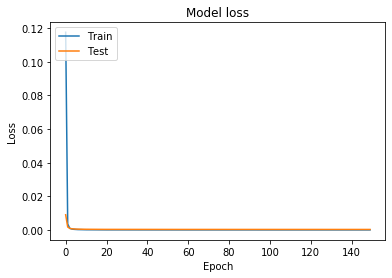

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Clustering

### K-Means
Summary: Given a clustering the LDA can be used to find a projection into a lower dimensional space which maximizes inter-class variance and minimizes intra-class variance. This leads to neater cluster, but is grounded in the hypotheses that the clusters have some real semantic meaning. Otherwise it may enforce preexisting biases.

In [ ]:
def clusterNumberHeuristic(tfs):
    return (tfs.shape[0]*tfs.shape[1])//tfs.count_nonzero()

def clusterkm(tfs_reduced, num_topics=10):
    km = KMeans(n_clusters=num_topics).fit(tfs_reduced)
    return km

### Agglomerative Clustering

In [17]:
ind = triu_indices(docs_vectorized_doc2vec.shape[0], 1)
wmds = np.zeros((docs_vectorized_doc2vec.shape[0], docs_vectorized_doc2vec.shape[0]))
euds = np.zeros((docs_vectorized_doc2vec.shape[0], docs_vectorized_doc2vec.shape[0]))
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

def wmd(x):
    return doc2vec_model.wv.wmdistance(mfndata[x[0]].words, mfndata[x[1]].words)

def eud(x):
    return norm(doc2vec_model[x[0]] - doc2vec_model[x[1]])

with Pool(cpu_count()) as p:
    wmds[ind] = p.map(wmd, zip(*ind))
    euds[ind] = p.map(eud, zip(*ind))
wmds = symmetrize(wmds)
euds = symmetrize(euds)

In [18]:
fig = go.Figure(data=[go.Box(y=(wmds/euds).flatten(),
            boxpoints='all', # can also be outliers, or suspectedoutliers, or False
            jitter=0.3, # add some jitter for a better separation between points
            pointpos=-1.8, # relative position of points wrt box
            name=""
              )])
fig.update_layout(
    title=go.layout.Title(
        xref="paper",
        x=0
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Quotient between WMD and Euclidian distance"
        )
    )
)

fig.show()

/tf/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [19]:
def clusterag(tfs_reduced, num_clusters=5):
    am = AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', memory='/tmp', linkage='average').fit(wmds)
    return am

# Embedding into 2D

## Linear Discriminant Analysis
*Summary*:
Given a clustering the LDA can be used to find a projection into a lower dimensional space which maximizes inter-class variance and minimizes intra-class variance. This leads to neater cluster, but is grounded in the hypotheses that the clusters have some real semantic meaning. Otherwise it may enforce preexisting biases.

In [ ]:
def dimReductionLDA(tfs_reduced, clusters, targetDim=2):
    lda = LinearDiscriminantAnalysis(n_components=targetDim)
    tfs_2d = lda.fit(tfs_reduced, clusters.labels_).transform(tfs_reduced)
    return tfs_2d, lda

## tSNE
*Summary*:


*In-depth explanation*:

In [ ]:
def dimReductiontSNE(tfs_reduced, perplexity=30, learning_rate=100, targetDim=2):
    print('t-SNE:')
    tfs_2d = %time TSNE(n_components=targetDim, perplexity=perplexity, learning_rate=learning_rate).fit_transform(tfs_reduced)
    return tfs_2d

# Linearize results into a grid

In [ ]:
def mapToSpaceSampling(points):
    # just take the first n² < #points Points
    points = points[: int(np.sqrt(len(points)))**2]
    grid = np.dstack(np.meshgrid(np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), int(np.sqrt(len(points)))),
                       np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), int(np.sqrt(len(points)))))).reshape(-1, 2)
    cost = cdist(points, grid, "sqeuclidean").astype(np.float64)
    cost *= 100000 / cost.max()
    row_ind_lapjv, col_ind_lapjv, _ = lapjv(cost, verbose=True, force_doubles=True)
    return grid[row_ind_lapjv]

In [ ]:
def computeClusterTopography(points, values, width, height, interpolation='linear'):
    # lay grid over the points so that all points are covered
    grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):width*1j, np.min(points[:,1]):np.max(points[:,1]):height*1j]
    return griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), method=interpolation, fill_value=np.min(values[:len(points)]))

In [ ]:
def compute(tfs, emb_model, targetDim, dimreduction, clustering, embedding, num_topics, num_clusters, perplexity, learning_rate, error, interpolation, viz, width, height):
    
    if dimreduction == 'LSA':
        tfs_reduced, red_model = LSA(tfs, num_topics=num_topics)
    elif dimreduction == 'Autoencoder':
        print('Autoencoder:')
        tfs_reduced, red_model = encoder_doc2vec.predict(tfs), None
    else:
        return 'No dimensionality reduction technique was selected!'
    
    if clustering == 'KMEANS':
        clusters = clusterkm(tfs_reduced, num_topics=num_clusters)
        cluster_centers_ = clusters.cluster_centers_
    elif clustering == 'Agglomerative Clustering':
        clusters = clusterag(tfs_reduced, num_clusters=num_clusters)
        cluster_centers_ = [np.mean(tfs[clusters.labels_[clusters.labels_ == x]]) for x in range(num_clusters)]
    else:
        return 'No clustering technique was selected!'
    
    sim_kernel = 1/(1+wmds)
    if embedding == 'LDA':
        tfs_embedded, lda = dimReductionLDA(tfs_reduced, clusters=clusters, targetDim=targetDim)
    elif embedding == 'tSNE':
        tfs_embedded = dimReductiontSNE(tfs_reduced, perplexity=perplexity, learning_rate=learning_rate, targetDim=targetDim)
    else:
        return 'No dimensionality reduction technique was selected!'
    
    # compute linearization
    tfs_mapped = mapToSpaceSampling(tfs_embedded) if targetDim == 2 else np.array([[0,0]]*len(tfs_embedded)) 
    
    # compute top words
    cluster_words = [emb_model.top_words(np.mean(tfs[clusters.labels_==cluster], axis=0), dct=dct, topn=5) for cluster in range(num_clusters)]
    top_words = [emb_model.top_words(project, dct=dct, topn=5) for project in tfs]
    # compute coherence score
    cm = CoherenceModel(topics=cluster_words, window_size=10, texts=[list(doc.words) for doc in traindata], dictionary=dct, processes=cpu_count())
    
    #compute cluster topography
    similarity_to_cluster_centers = silhouette_samples(tfs_embedded, labels=clusters.labels_)
    #reduction_error = np.max(lda.decision_function(tfs_reduced), axis=1) if (embedding == 'LDA') else [0]* len(tfs_embedded)
    #eduction_error = reduction_error / norm(reduction_error)
    interpolated_topography = computeClusterTopography(tfs_embedded if viz == 'scatter' else tfs_mapped, silhouette_samples(tfs_reduced, clusters.labels_), width, height, interpolation)
    #interpolated_topography = np.array([1])*len(interpolated_topography)
    return tfs_reduced, clusters, tfs_embedded, tfs_mapped, cluster_words, top_words, similarity_to_cluster_centers, interpolated_topography, cm

# Visualization

In [ ]:
def draw_scatter(data, width=600, height=600, viz='scatter'):
    display(Javascript("""
        (function(element){
            require(['scatter'], function(scatter) {
                scatter(element.get(0), %s, %d, %d, %s);
            });
        })(element);
    """ % (json.dumps(data), width, height, json.dumps(viz))))

In [ ]:
def save(payload):
    name = "c" + str(payload['params']['num_clusters']) +"-t" + str(payload['params']['num_topics']) + "_" + str(payload['params']['embedding'])
    if payload['params']['embedding'] == 'tSNE':
        name += "_p" + str(payload['params']['perplexity']) + "-lr" + str(payload['params']['learning_rate'])
    with open('./dumps/' + name + '.json', 'w') as dumpfile:
        json.dump(payload, dumpfile, sort_keys=True, indent=4, ensure_ascii=False)

In [ ]:
def visualize(targetDim=2,tfs=None,dimreduction='LSA', clustering='KMEANS', embedding='LDA', num_topics=20, granularity=5, perplexity=5, learning_rate=200, error='cluster_error', interpolation='linear', viz='scatter', fake=''):
    # viz dimensions
    num_clusters=granularity
    width = 600
    height = 600
    payload = {}
    
    
    if not fake:
        # compute all necessary stuff
        tfs, model = pickle.loads(tfs)
        tfs_reduced, clusters, tfs_embedded, tfs_mapped, cluster_words, top_words, similarity_to_cluster_centers, interpolated_topography, cm = compute(tfs, model, targetDim, dimreduction, clustering, embedding, num_topics, num_clusters, perplexity, learning_rate, error, interpolation, viz, width, height)

        [print(i, words) for i,words in enumerate(cluster_words)]
        colours = d3['Category20'][num_clusters]
        #ids, titles, texts = [list(elem) for elem in zip(*loadProjects())]
        if targetDim == 2:
            # configure bokeh plot                   
            source = ColumnDataSource(data=dict(
                x=tfs_embedded[:, 0],
                y=tfs_embedded[:, 1],
                x_mapped=tfs_mapped[:, 0],
                y_mapped=tfs_mapped[:, 1],
                ids=mfndata.getIDs(),
                titles=mfndata.getTitles(),
                colours=np.array(colours)[clusters.labels_],
                labels=clusters.labels_
            ))

            TOOLTIPS = [
                ("index", "$index"),
                ("id", "@ids"),
                ("title", "@titles"),
            ]
            # scatterplot
            scatter = figure(plot_width=800, plot_height=800, title=None, toolbar_location="below", tooltips=TOOLTIPS, tools='tap,pan,wheel_zoom,save')
            scatter.scatter('x', 'y', size=10,color='colours', legend='labels', source=source)
            url = 'http://gepris.dfg.de/gepris/projekt/@ids'
            taptool = scatter.select(type=TapTool)
            taptool.callback = OpenURL(url=url)

            # mapped scatterplot
            mapped_scatter = figure(plot_width=800, plot_height=800, title=None, toolbar_location="below", tooltips=TOOLTIPS, tools='tap,pan,wheel_zoom')
            mapped_scatter.scatter('x_mapped', 'y_mapped', size=50,color='colours', legend='labels', source=source)
            url = 'http://gepris.dfg.de/gepris/projekt/@ids'
            taptool = mapped_scatter.select(type=TapTool)
            taptool.callback = OpenURL(url=url)
            #show(row(scatter, mapped_scatter))
        else:

            source = go.Scatter3d(
                x=tfs_embedded[:, 0],
                y=tfs_embedded[:, 1],
                z=tfs_embedded[:, 2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=clusters.labels_,                # set color to an array/list of desired values
                    colorscale='Viridis',   # choose a colorscale
                    opacity=0.8
                )
            )

            data = [source]
            layout = go.Layout(
                margin=dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0
                )
            )
            fig = go.Figure(data=data, layout=layout)
            iplot(fig, filename='3d-scatter-colorscale')

        payload = {
            'params': {
                'targetDim': targetDim,
                'dimreduction': dimreduction,
                'clustering': clustering,
                'embedding': embedding,
                'num_topics': num_topics,
                'num_clusters': num_clusters,
                'perplexity': perplexity,
                'learning_rate': learning_rate
            },
            'project_data': [{'id':pid,'reducedpoint': reducedpoint, 'embpoint':embpoint, 'mappoint':mappoint, 'cluster':cluster, 'error':error, 'title': title, 'words': words} for pid, reducedpoint, embpoint, mappoint, cluster, error, title, words in zip(
                mfndata.getIDs(),
                tfs_reduced.tolist(),
                tfs_embedded.tolist(),
                tfs_mapped.tolist(),
                clusters.labels_.tolist(),
                similarity_to_cluster_centers.tolist(),
                mfndata.getTitles(),
                top_words

            )],
            'cluster_data': {
                'cluster_words': cluster_words,
                'cluster_colour': colours
            },
            'cluster_topography': np.flip(interpolated_topography.T, axis=0).flatten().tolist()
        }
        save(payload)
    else:
        with open(fake, 'r') as input_data:
            payload = payload=json.load(input_data)
    display(HTML(filename="scatter.css.html"))
    display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
    display(Javascript(filename="scatter.js"))
    draw_scatter(payload, width, height, viz)
        


In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
def s(x,y):
    return IntSlider(min=x,max=y, value=(y-x)//2, continuous_update=False)

def f(x,y):
    return FloatSlider(min=x,max=y, value=(y-x)//2, step=0.0001, continuous_update=False)

w = interactive(visualize,targetDim=fixed(2),tfs=fixed(pickle.dumps((docs_vectorized_tfidf, tfidf_model))), dimreduction=fixed('LSA'), clustering=fixed('KMEANS'), embedding=fixed('LDA'),num_topics=fixed(50), granularity=s(3,10), perplexity=fixed(5), learning_rate=fixed(10),error=fixed('silhouette'), interpolation=fixed('linear'), viz=['scatter', 'linearized'], fake=fixed(''))
#output = w.children[-1]
#output.layout.height = '2000px'
display(w)


interactive(children=(IntSlider(value=3, continuous_update=False, description='granularity', max=10, min=3), D…

### Evaluate topic extraction

In [29]:
# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Doc2Vec + LSA", "Doc2Vec + Autoencoder", "TfIdf + LSA", "TfIdf + Autoencoder")
)

# Update xaxis properties
#fig.update_xaxes(title_text="xaxis 1 title", row=1, col=1)
#fig.update_xaxes(title_text="xaxis 2 title", range=[10, 50], row=1, col=2)
#fig.update_xaxes(title_text="xaxis 3 title", showgrid=False, row=2, col=1)
#fig.update_xaxes(title_text="xaxis 4 title", type="log", row=2, col=2)

# Update yaxis properties
#fig.update_yaxes(title_text="yaxis 1 title", row=1, col=1)
#fig.update_yaxes(title_text="yaxis 2 title", range=[40, 80], row=1, col=2)
#fig.update_yaxes(title_text="yaxis 3 title", showgrid=False, row=2, col=1)
#fig.update_yaxes(title_text="yaxis 4 title", row=2, col=2)

# Update title and height
#fig.update_layout(title_text="Customizing Subplot Axes", height=700)

def compute_cms(num_clusters):
    cms = []
    for rerun in range(3):
        tfs, model = pickle.loads(embmodel)
        *args, cm = compute(tfs, model, 2, dimreduction, clustering, 'LDA', 50, num_clusters, 5, 100, 'cluster_error', 'linear', 'scatter', 10, 10)
        print(cm)
        cms.append(cm.get_coherence())
    return sum(cms)/len(cms)


for i,(name,embmodel) in enumerate([('Doc2Vec', pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), ('TfIdf', pickle.dumps((docs_vectorized_tfidf, tfidf_model)))]):
    for j,dimreduction in enumerate(['LSA', 'Autoencoder']):
        if name == 'TfIdf' and dimreduction =='Autoencoder':
            continue
        for clustering in ['KMEANS', 'Agglomerative Clustering']:
            data = []
            dims = list(range(3, 15))
            data = [compute_cms(dim) for dim in dims]
            fig.add_trace(go.Scatter(x=dims, y=data, name=clustering, marker_color="red" if clustering == 'KMEANS' else "blue", showlegend=True if (i==0 and j==0) else False), row=i+1, col=j+1)
fig.update_xaxes(title_text="Number of clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of clusters", row=1, col=2)
fig.update_xaxes(title_text="Number of clusters", row=2, col=1)

fig.update_yaxes(title_text="Coherence score", row=1, col=1)
fig.update_yaxes(title_text="Coherence score", row=1, col=2)
fig.update_yaxes(title_text="Coherence score", row=2, col=1)
fig.show()

Coherence_Measure(seg=<function s_one_set at 0x7f50c810c400>, prob=<function p_boolean_sliding_window at 0x7f50c810c620>, conf=<function cosine_similarity at 0x7f50c7ebbd90>, aggr=<function arithmetic_mean at 0x7f50c77d7378>)
Coherence_Measure(seg=<function s_one_set at 0x7f50c810c400>, prob=<function p_boolean_sliding_window at 0x7f50c810c620>, conf=<function cosine_similarity at 0x7f50c7ebbd90>, aggr=<function arithmetic_mean at 0x7f50c77d7378>)
Coherence_Measure(seg=<function s_one_set at 0x7f50c810c400>, prob=<function p_boolean_sliding_window at 0x7f50c810c620>, conf=<function cosine_similarity at 0x7f50c7ebbd90>, aggr=<function arithmetic_mean at 0x7f50c77d7378>)
Coherence_Measure(seg=<function s_one_set at 0x7f50c810c400>, prob=<function p_boolean_sliding_window at 0x7f50c810c620>, conf=<function cosine_similarity at 0x7f50c7ebbd90>, aggr=<function arithmetic_mean at 0x7f50c77d7378>)
Coherence_Measure(seg=<function s_one_set at 0x7f50c810c400>, prob=<function p_boolean_sliding_w

E0827 20:17:46.138263 139986002310976 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/tf/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-dd8319c96617>", line 38, in <module>
    data = [compute_cms(dim) for dim in dims]
  File "<ipython-input-29-dd8319c96617>", line 38, in <listcomp>
    data = [compute_cms(dim) for dim in dims]
  File "<ipython-input-29-dd8319c96617>", line 24, in compute_cms
    tfs, model = pickle.loads(embmodel)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tf/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tf/.venv/lib/pyth

KeyboardInterrupt: 

In [33]:
def s(x,y):
    return IntSlider(min=x,max=y, value=(y-x)//2, continuous_update=False)

w = interactive(visualize,targetDim=s(2,3),tfs=Dropdown(options=[('Doc2Vec', pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), ('TfIdf', pickle.dumps((docs_vectorized_tfidf, tfidf_model)))], value=pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), dimreduction=['LSA', 'NMF', 'Autoencoder'], clustering=['KMEANS'], embedding=['LDA', 'tSNE'], num_topics=s(4,48), num_clusters=s(4,10), perplexity=s(5,50), learning_rate=s(100,1000),error=['silhouette', 'cluster_error'], interpolation=['linear', 'cubic', 'nearest'], viz=['scatter', 'linearized'], fake='')
output = w.children[-1]
#output.layout.height = '2000px'
display(w)


interactive(children=(IntSlider(value=2, continuous_update=False, description='targetDim', max=3, min=2), Drop…